<a href="https://colab.research.google.com/github/korsakjakub/kwant-tutorials-zps/blob/master/posts/2022-10-01-One-dimensional-scattering-in-kwant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kwant
import matplotlib.pyplot as plt
import numpy as np

In [3]:
JtomeV = 6.242 * 10**21
mevtoJ = JtomeV ** (-1)
hbar = 1.0545718 * 10 ** (-34)  # m^2 kg/s
hbarr = 6.58211 * 10 ** (-13)  # meV s
me = 9.10938356 * 10 ** (-31)  # kg
mc = 1.782 * 10 ** (-36)  ##eV/c^2 = mc kg
c = 3 * 10**8
a = 0.5 * 10 ** (-9)  # m
meff = 0.07  # non dim
t = (hbar) ** 2 / (2 * meff * me * a**2) * JtomeV  # j->mev
l = 5 * 10 ** (-8)
L = int(l / a)
v0 = 20

syst = kwant.Builder()
lat = kwant.lattice.chain(a)

def an_sol(E, V0=v0, L=0.8 * l):
    E = np.array(E) * mevtoJ
    V0 *= mevtoJ
    m = me * meff
    k2 = np.sqrt(abs(2 * m * (E - V0)) * hbar ** (-2))
    v = []

    for i in range(np.size(E)):
        kd = k2[i]
        e = E[i]
        if E[i] < 0.999999 * V0:
            t = V0**2 * np.sinh(kd * L) ** 2 / (4 * e * (V0 - e))
            v.append(t)
        elif E[i] > 1.0000001 * V0:
            t = V0**2 * np.sin(kd * L) ** 2 / (4 * e * (e - V0))
            v.append(t)
    v = np.array(v)
    return 1 / (1 + v)

In [4]:
def v(x, p=L / 10.0, k=9 * (L / 10.0), V=v0):
    if x < p:
        return 0
    if x >= p and x <= k:
        return V
    if x > k:
        return 0

In [5]:
def v_g(x, v=v0, w=2 * L / 5.0, n=50, V=v0):
    return V * np.exp(-(((x - L / 2.0) / w) ** n))

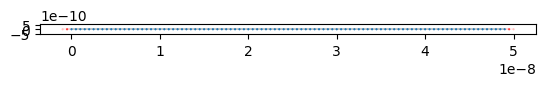

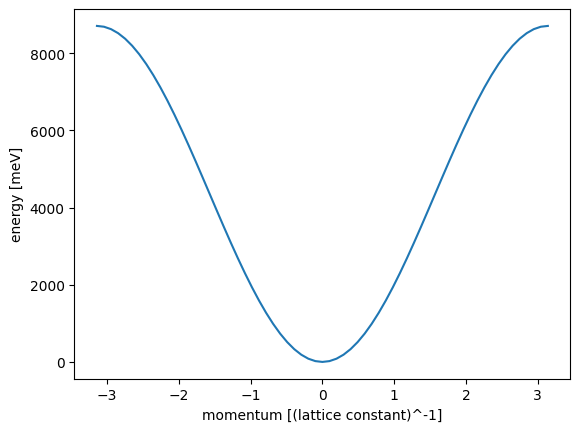

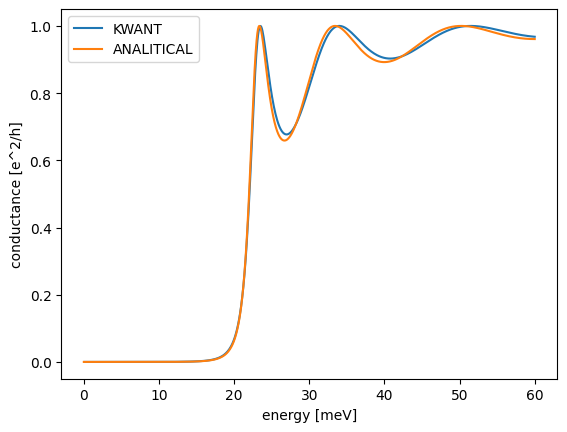

In [6]:
# build
for i in range(L):
    syst[lat(i)] = 2 * t + v_g(i)
    # hopping
    if i > 0:
        syst[lat(i), lat(i - 1)] = -t

# left lead
sym_left_lead = kwant.TranslationalSymmetry([-a])
left_lead = kwant.Builder(sym_left_lead)
left_lead[lat(0)] = 2 * t
left_lead[lat(0), lat(1)] = -t
syst.attach_lead(left_lead)

# right lead
sym_right_lead = kwant.TranslationalSymmetry([a])
right_lead = kwant.Builder(sym_right_lead)
right_lead[lat(0)] = 2 * t
right_lead[lat(0), lat(1)] = -t
syst.attach_lead(right_lead)
right_lead = right_lead.finalized()

kwant.plot(syst)
syst = syst.finalized()
kwant.plotter.bands(right_lead, show=False)
plt.xlabel("momentum [(lattice constant)^-1]")
plt.ylabel("energy [meV]")
plt.show()

energies = []
data = []

n = 800
Emax = 3 * v0
for ie in range(n):
    energy = Emax * (ie + 1) / n  # mev
    smatrix = kwant.smatrix(syst, energy)
    energies.append(energy)
    data.append(smatrix.transmission(1, 0))

plt.figure()
plt.plot(energies, data, label="KWANT")


energy=np.linspace(0.001, Emax, 10000)
t = an_sol(energy)
plt.plot(energy, t, label="ANALITICAL")

plt.xlabel("energy [meV]")
plt.ylabel("conductance [e^2/h]")

plt.legend()
plt.show()